## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Indlæs data
df_reviews = pd.read_csv("reviews.txt", header=None, names=["review"], encoding="utf-8")
df_labels  = pd.read_csv("labels.txt",  header=None, names=["label"], encoding="utf-8")

X = df_reviews.review
y = df_labels.label

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

## Input-lag


In [12]:
# Split i 20% test, 30% validering og 70% training

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.30, random_state=42)

print(f"Training: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Training: 14000, Validation: 6000, Test: 5000


In [13]:
# Bag of words på de 10.000 mest hyppige ord

# Vektorisér data
# "Vi bruger CountVectorizer til at omdanne tekst til en BoW-repræsentation. Det betyder, at hvert ord bliver en kolonne, og hver anmeldelse bliver en række i en matrix. Hvis et ord optræder to gange i en anmeldelse, står der 2 i den tilhørende celle. Modellen får dermed en numerisk vektor for hver tekst, som den kan bruge til træning."

vectorizer = CountVectorizer(max_features=10000)

# BoW, finder de 10.000 mest brugte ord, laver en kolonne pr. ord. Hver tekst bliver en vektor. Output = talmatrice
X_train_words = vectorizer.fit_transform(X_train)
X_val_words = vectorizer.transform(X_val)
X_test_words = vectorizer.transform(X_test)

print("Train:", X_train_words.shape)
print("Val:", X_val_words.shape)
print("Test:", X_test_words.shape)

Train: (14000, 10000)
Val: (6000, 10000)
Test: (5000, 10000)


**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

['abandon' 'abandoned' 'abby' 'abc' 'abducted' 'abilities' 'ability'
 'able' 'aboard' 'abominable']


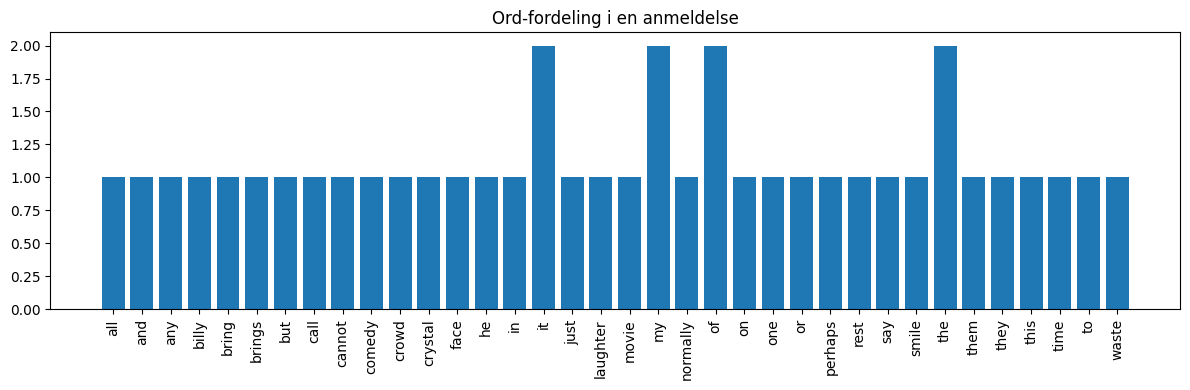

In [14]:
# Repræsentation af enkelte ord
feature_names = vectorizer.get_feature_names_out()
print(feature_names[:10])

# Repræsentation af en anmeldelse
row_vector = X_train_words[0]
dense_vector = row_vector.toarray()[0]

plt.figure(figsize=(12, 4))
plt.bar(
    [feature_names[i] for i in range(len(dense_vector)) if dense_vector[i] > 0],
    [dense_vector[i] for i in range(len(dense_vector)) if dense_vector[i] > 0]
)
plt.xticks(rotation=90)
plt.title("Ord-fordeling i en anmeldelse")
plt.tight_layout()
plt.show()

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy.

### Skjult-lag
Et skjult lag er et **mellemled mellem input og output**, som netværket selv lærer at justere.
Neuronerne i de skjulte lag lærer at genkende komplekse mønstre og signaler, som ikke er direkte synlige i inputdataene.

I denne opgave anvendes et skjult lag til at bearbejde de 10.000 input-funktioner fra Bag-of-Words og kombinere dem til mere **abstrakte, meningsfulde mønstre**.
Det skjulte lag hjælper modellen med at identificere hvilke typer ord, vendinger eller kombinationer, der typisk forbindes med **positive eller negative anmeldelser.**

#### ReLU
Der anvendes **ReLU**(Recitied Linear Unit) som aktiveringsfunktion i det skjulte lag.
ReLU vælges fordi den:
- Er hurtig til at beregne
- Bevarer gradienten for positive input
- Undgår problemer med saturering, hvor gradienten ellers forsvinder

Alternativer:
 - **Tanh**, fungerer bedre end sigmoid i skjulte lag, men er stadig langsommere og kan saturere
 - **Sigmoid** frarådes i skjulte lag, da gradienten hurtigt forsvinder ved ekstreme værdier

### Output-lag
Der er to sentiment-klasser i opgaven: positiv og negativ.
Det gør opgaven til en binær klassifikation, hvor modellen skal forudsige om en anmeldelse tilhører klasse 1 (positiv) eller 0 (negativ).

#### Sigmoid
I denne opgave anvendes Sigmoid som aktiveringsfunktion i output-laget
Sigmoid-funktionen returnerer et output mellem 0 - 1, som kan tolkes som en sandsynlighed for, at input hører til klasse 1 (positiv anmeldelse).

Når output er > 0.5, tolkes det som klasse 1, ellers klasse 0(negativ)

Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7776 - loss: 0.4768 - val_accuracy: 0.8742 - val_loss: 0.3198
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9328 - loss: 0.1935 - val_accuracy: 0.8772 - val_loss: 0.3172
Epoch 3/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9610 - loss: 0.1218 - val_accuracy: 0.8642 - val_loss: 0.3839


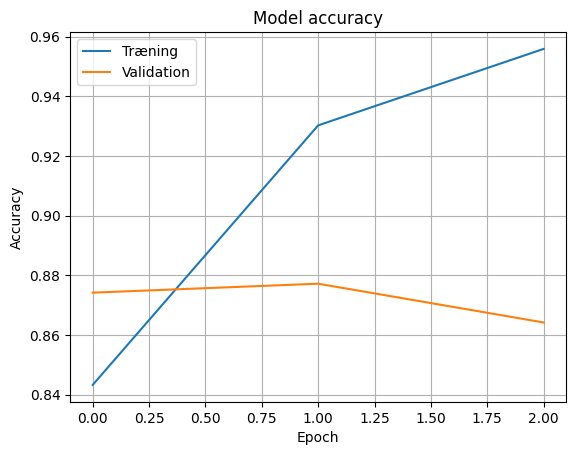

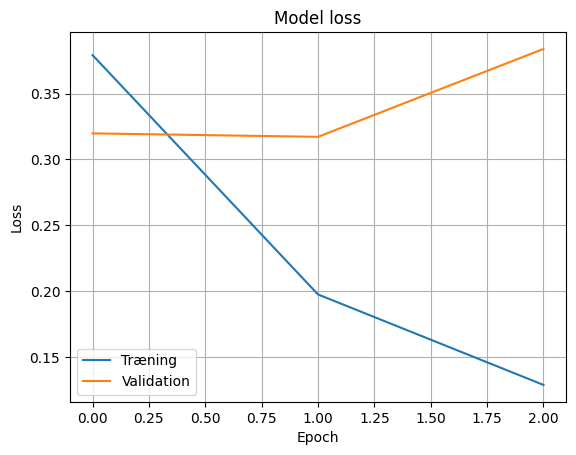

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Konverter tekst-labels til 0/1
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val   = encoder.transform(y_val)
y_test  = encoder.transform(y_test)

# Konverter til float32 (som TensorFlow kræver)
y_train = y_train.astype("float32")
y_val   = y_val.astype("float32")
y_test  = y_test.astype("float32")


# Definering af modellen
model = tf.keras.Sequential([
    tf.keras.Input(shape=(10000,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Kompilér modellen
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Træn modellen
# epochs justeret fra 10, hvor den overfittede til 3, da vi kan se på grafen at den er bedst efter 1-2
history = model.fit(X_train_words, y_train, epochs=3, batch_size=32, validation_data=(X_val_words, y_val))

# Plotting af træningskurver

# Accuracy
plt.plot(history.history["accuracy"], label="Træning")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history["loss"], label="Træning")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

En epoch er én fuld gennemgang af hele træningssættet. Jeg trænede modellen i 3 epochs og fulgte udviklingen i accuracy og loss.

Accuracy/Epoch
Kurven

Loss/Epoch
Loss måler, hvor langt modellen er fra det rigtige svar. Lav loss = god model. Træning loss falder pænt = modellen lærer, validation loss stiger = modellen begynder at fejlklassificere nye anmeldelser. Når val-loss stiger, mens val-loss falder, er det et klart tegn på overfitting


Jeg kunne se, at træningsnøjagtigheden steg, men valideringsnøjagtigheden begyndte at falde – og valideringsloss steg. Det indikerer overfitting. Derfor bør man evt. stoppe tidligere (early stopping) eller bruge dropout og regularisering.

**(d)** Test your sentiment-classifier on the test set.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Klassifikationsrapport:

              precision    recall  f1-score   support

    Negative       0.82      0.92      0.87      2492
    Positive       0.92      0.80      0.86      2508

    accuracy                           0.86      5000
   macro avg       0.87      0.86      0.86      5000
weighted avg       0.87      0.86      0.86      5000



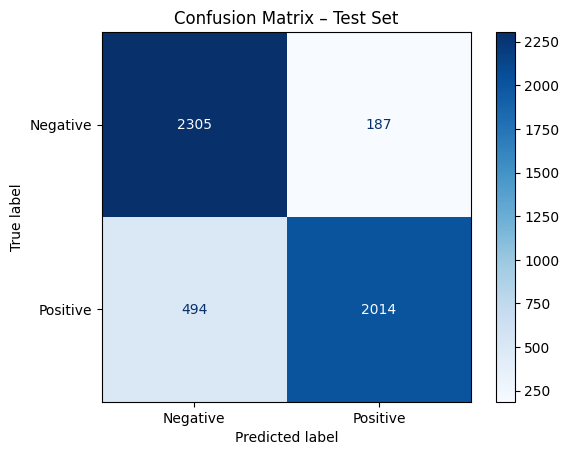

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8623 - loss: 0.3927
Test accuracy: 0.8638
Test loss: 0.3936


In [20]:
# Efter træning og validering evaluerede jeg min sentiment-klassifikationsmodel på det tilbageholdte test-sæt. Det giver et retvisende billede af, hvor godt modellen generaliserer til nye anmeldelser. Jeg rapporterede både accuracy og loss – hvor accuracy angiver andelen af korrekt klassificerede anmeldelser, og loss viser hvor godt sandsynlighederne matcher de rigtige labels.

# Efter træning og tuning evaluerede jeg modellen på test-sættet, som den aldrig har set før. Jeg brugte både accuracy, confusion matrix og en klassifikationsrapport med precision, recall og F1-score. Confusion matrix viser hvor mange anmeldelser der blev korrekt klassificeret som positive eller negative, og hvor fejlene ligger. Jeg satte sandsynlighedsgrænsen ved 0.5, hvilket betyder, at alt over 50% tolkes som positivt sentiment.

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Forudsig klasser (baseret på sandsynligheder)
y_pred_probs = model.predict(X_test_words)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Klassifikationsrapport
report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
print("Klassifikationsrapport:\n")
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.grid(False)
plt.show()


# Evaluér modellen på testdata
test_loss, test_accuracy = model.evaluate(X_test_words, y_test, verbose=1)

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


### Overordnet vurdering
Test accuracy: 0.8638
→ Modellen præsterer stabilt godt på ukendte data (hvilket er målet).

Test loss: ~0.39
→ Sandsynlighederne er ikke perfekte, men stadig fornuftigt lave.

#### Tolkning
Positive anmeldelser har høj precision (0.92), men lavere recall (0.80)
→ Modellen gætter sjældent forkert når den siger positiv, men overser nogle positive anmeldelser

Negative anmeldelser har lidt lavere precision, men høj recall
→ Modellen er bedre til at finde negative anmeldelser generelt

Dette betyder, at modellen er lidt biased mod at kalde ting "negative" når den er i tvivl — hvilket er typisk ved ubalancerede eller nuancerede data.

#### Confusion matrix
True Negatives (2305): korrekt klassificerede negative

False Negatives (494): positive anmeldelser som fejlagtigt blev kaldt negative
→ det største problem

False Positives (187): negative anmeldelser fejlagtigt kaldt positive
→ relativt lavt antal

Jeg evaluerede min sentiment-klassifikationsmodel på et test-sæt, den aldrig har set før.
Test accuracy lå på 86 %, og confusion matrix viser, at modellen er god til at klassificere negative anmeldelser korrekt (92 % recall), men har lidt sværere ved at genkende alle de positive (80 % recall).
Precision for positive anmeldelser er høj (92 %), hvilket betyder, at når modellen siger “positiv”, har den som regel ret.
Jeg tolker resultaterne som tegn på en robust model med svag overfitting og en vis bias mod negativ klassificering, som kan forbedres med fx mere afbalancerede data, justering af thresholds eller brug af class_weight.

**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [25]:
# Jeg har testet modellen på egne sætninger. Jeg transformerede dem med samme Bag-of-Words-model som træningsdata, og brugte den trænede model til at forudsige sentiment. Modellen returnerer en sandsynlighed mellem 0 og 1 via sigmoid-aktiveringsfunktionen. Jeg fortolker resultater over 0.5 som “positive”, og under 0.5 som “negative”.


# Dine egne sætninger
custom_sentences = [
    "Excellent plot and great characters! loved the movie",
    "The best movie I have seen in a while, I never want to watch it again",
    "The absolute greatest waste of time ever",
    "Horrible movie and terrible acting",
    "Absolutely loved how the plot made no sense and the characters were completely unbelievable.",
    "Taken 3 makes Taken 2 look like Taken 1",
    "Megalopolis is an Ambitious Art Film So Bad It Made Me Hate Ambition, Art and Film"
]

# Vektoriser sætningerne
custom_bow = vectorizer.transform(custom_sentences).toarray()

# Brug modellen til at forudsige
pred_probs = model.predict(custom_bow).flatten()

# Print resultater
for sentence, prob in zip(custom_sentences, pred_probs):
    label = "Positive" if prob > 0.5 else "Negative"
    print(f"{label} ({prob:.2f}) → {sentence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Positive (0.82) → Excellent plot and great characters! loved the movie
Positive (0.73) → The best movie I have seen in a while, I never want to watch it again
Negative (0.29) → The absolute greatest waste of time ever
Negative (0.20) → Horrible movie and terrible acting
Negative (0.25) → Absolutely loved how the plot made no sense and the characters were completely unbelievable.
Positive (0.62) → Taken 3 makes Taken 2 look like Taken 1
Negative (0.42) → Megalopolis is an Ambitious Art Film So Bad It Made Me Hate Ambition, Art and Film


Modellen klarede sig over forventning på sætninger med ironi og sarkasme. Eksempelvis klassificerede den korrekt en sætning med “Absolutely loved...” i starten, men med klart negative vendinger efterfølgende. Det tyder på, at modellen ikke kun reagerer på enkelte sentiment-ord, men også lærer hvilke kombinationer og mønstre der er typisk positive eller negative.